# AircraftFuelConsumption
Competition with dataset:https://www.crowdanalytix.com/contests/predict-fuel-flow-rate-of-airplanes-during-different-phases-of-a-flight

# Imoptrs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/FuelProject/data'

/content/drive/My Drive/FuelProject/data


In [0]:
!pip3 install eli5
!pip3 install pdpbox
!pip3 install category_encoders

In [0]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import imports

# Data

In [0]:
test_sam = pd.read_csv("CAX_Test_sub.csv")

In [0]:
traine = pd.read_csv("train_unstruc.csv")

In [0]:
traine = remove_rows_val(traine, "Year", "Year")
traine = drop_unvariance(traine)
traine = elapsed(traine, 1, 7)

# Train test selection

In this section RF is used to predict which line is from test set and which from train set. Then feature importance shows difference beween thouse sets.


In [0]:
train_sam=traine.sample(50000)

In [0]:
test_sam.drop(columns=["FF"], inplace=True)
train_sam.drop(columns=["FF", "elapsed"], inplace=True)
test_sam["Predictor"] = 0
train_sam["Predictor"] = 1
search_df = test_sam[train_sam.columns].append(train_sam)

In [0]:
split_model = RandomForestClassifier(n_estimators=75)
split_model.fit(search_df.drop(columns=["Predictor"]), search_df["Predictor"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

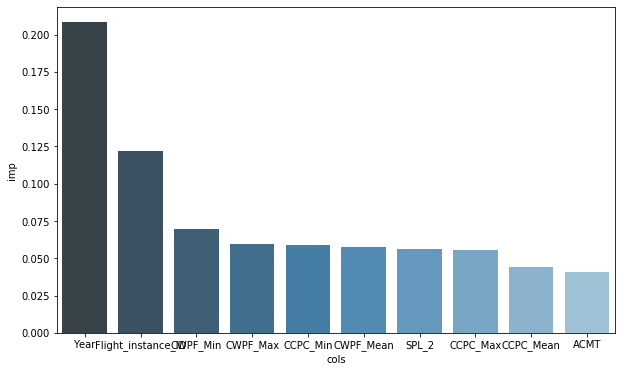

In [0]:
_ = feat_importance(
    split_model.feature_importances_, search_df.drop(columns=["Predictor"]), True
)

In [0]:
print("Train: " + str(train_sam["Year"].unique()))
print("Test: " + str(test_sam["Year"].unique()))

Train: [2002. 2004. 2003.]
Test: [2001.]




*   This bar chart shows that Data in test set is from years before train data.
*   "Flight_instance_ID" in different sets should not intercept.



#Mixed data

Data in this dataset is taken randomly form different flights. So model can approximate better.

In [0]:
val_X, val_y, rest = mix_split(
    traine, ["Year", "Month"], "FF", "Flight_instance_ID", 50000
)
test_X, test_y, rest = mix_split(
    rest, ["Year", "Month"], "FF", "Flight_instance_ID", 50000
)
train_X, train_y, _ = mix_split(
    rest.sample(350000), ["Year", "Month"], "FF", "Flight_instance_ID", -1
)

#Complete data

This dataset contains all known data about each flight in it. So there is more opportunities for preprocessing.

In [0]:
traine_cm = pd.read_csv("train_struc.csv")
traine_cm = remove_rows_val(traine_cm, "Year", "Year")
traine_cm = elapsed(traine_cm, 2, 8)

In [8]:
traine_cm["Flight_instance_ID"].unique().size

143

In this set there is data about 143 unique flights

In [9]:
traine_cm.head(5)

,ACID,Flight_instance_ID,Year,Month,Day,Hour,Minute,Second,ABRK,ELEV_1,ELEV_2,EVNT,FADF,FADS,FGC3,FIRE_1,FIRE_2,FIRE_3,FIRE_4,FLAP,FQTY_1,FQTY_2,FQTY_3,FQTY_4,GLS,GPWS,HDGS,HF1,HF2,HYDG,HYDY,ILSF,LATP,LMOD,LOC,LONP,MNS,MRK,MW,N1CO,...,WS_Mean,WS_Min,WS_Max,RALT_Mean,RALT_Min,RALT_Max,ROLL_Mean,ROLL_Min,ROLL_Max,VRTG_Mean,VRTG_Min,VRTG_Max,CTAC_Mean,CTAC_Min,CTAC_Max,FPAC_Mean,FPAC_Min,FPAC_Max,IVV_Mean,IVV_Min,IVV_Max,ACMT,AIL_1,AIL_2,ALTS,APFD,A_T,BLV,BPGR_1,BPGR_2,BPYR_1,BPYR_2,CALT,CASS,CRSS,DFGS,DWPT,EAI,FF,elapsed
145706,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,12.0,119.96891,21.908501,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,95.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,-0.005488,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.78125,-0.875,-0.75,-0.406483,-0.406483,-0.406483,0.988978,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-0.8750,-1.0,0.0,60.0,85.086838,81.997681,5000.0,2.0,1.0,0.0,0.0,48.828247,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09
145707,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,13.0,119.96891,21.908501,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,94.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,0.000000,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.81250,-0.875,-0.75,-0.402363,-0.406483,-0.395497,0.988120,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-1.0000,-1.0,-1.0,60.0,85.086838,81.956764,5000.0,2.0,1.0,0.0,0.0,43.945423,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09
145708,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,14.0,119.96891,21.928959,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,94.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,-0.001176,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.81250,-0.875,-0.75,-0.406483,-0.406483,-0.406483,0.988120,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-0.5000,-1.0,0.0,60.0,85.086838,81.977219,5000.0,2.0,1.0,0.0,0.0,48.828247,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09
145709,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,15.0,119.96891,21.908501,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,95.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,-0.001764,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.78125,-0.875,-0.75,-0.405110,-0.406483,-0.395497,0.988120,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-0.1250,-1.0,0.0,60.0,85.066376,81.977219,5000.0,2.0,1.0,0.0,0.0,48.828247,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09
145710,676.0,6.762010e+14,2002.0,3.0,9.0,14.0,56.0,16.0,119.96891,21.908501,60.578156,1.0,15.0,15.0,120.0,0.0,0.0,0.0,0.0,94.0,8072.0,0.0,0.0,7928.0,-0.00156,1.0,-120.057738,1.0,1.0,0.0,0.0,100.0,33.56392,12.0,-0.013132,-86.749769,208.0,7.0,0.0,1.0,...,0.0,0.0,0.0,-0.78125,-0.875,-0.75,-0.399617,-0.406483,-0.395497,0.988120,0.987834,0.990123,0.0,0.0,0.0,0.0,0.0,0.0,-0.3125,-1.0,0.0,60.0,85.086838,81.997681,5000.0,2.0,1.0,0.0,0.0,43.945423,2036.137939,0.0,0.0,137.0,-60.028868,1.0,60632.0,0.0,0.0,1.015686e+09


In [0]:
traine_cm = smart_subsample(traine_cm, "Flight_instance_ID", 3000)
traine_cm = drop_unvariance(traine_cm)

In [0]:
train = traine_cm
val_X, val_y = clean_split(traine_cm, 0, 20, "FF")
test_X, test_y = clean_split(traine_cm, 20, 40, "FF")

In [0]:
train_X, train_y = clean_split(traine_cm, 40, -1, "FF")

# A little bit of analysis

In [0]:
featcorr = CorrCount(train_X, 0.9)

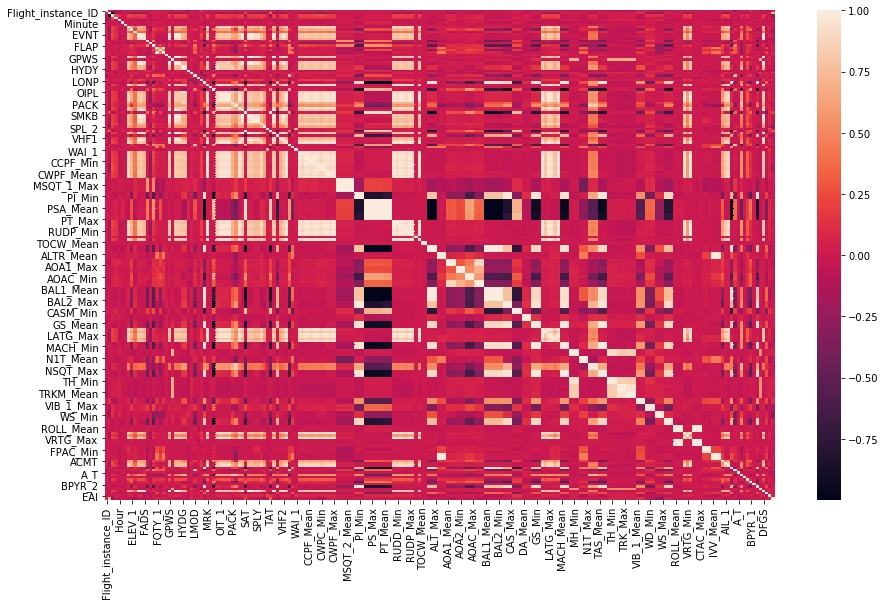

In [14]:
fig, axbo = plt.subplots(1, 1, figsize=(15, 9))
sns.heatmap(featcorr.correlation, ax=axbo)
plt.show()

We can see that in date set many independent features duplicate each other.

#PH analys

This charts represents average fuel consumption during different phases of the flight.

In [0]:
phticks = [
    "Unknown",
    "Preflight",
    "Taxi",
    "Takeoff",
    "Climb",
    "Cruise",
    "Approuch",
    "Rollout",
]

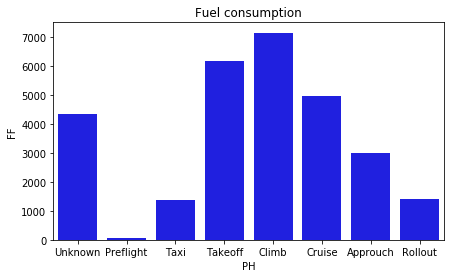

In [16]:
phan = pd.DataFrame(train.groupby("PH").mean()["FF"])
fig, axbo = plt.subplots(1, 1, figsize=(7, 4))
sns.barplot(x=phan.index, y="FF", data=phan, color="blue", ax=axbo)
axbo.set_xticklabels(phticks)
axbo.title.set_text("Fuel consumption")
plt.show()

More about phases: https://www.fp7-restarts.eu/index.php/home/root/state-of-the-art/objectives/2012-02-15-11-58-37/71-book-video/parti-principles-of-flight/126-4-phases-of-a-flight.html

# First model

Mask for training data subsample to train models faster:

In [0]:
msks = 50000
mask = np.concatenate([np.zeros(train_X.shape[0] - msks), np.ones(msks)]).astype("bool")
np.random.shuffle(mask)

First model is calculating of MSE for mean of train set.

In [18]:
rmse(test_y, [train_y.mean()] * test_y.shape[0])

2335.0480297067966

Second model is just RF with random hyper parameters

In [19]:
pre_mod = RandomForestRegressor(n_estimators=25, max_features=100)
pre_mod.fit(train_X[mask].drop(columns="Flight_instance_ID"), train_y[mask])
rmse(test_y, pre_mod.predict(test_X.drop(columns="Flight_instance_ID")))

225.08287937188396

# Important Features

This cell is about sellecting important features for models. To cover different types of dependencies I use 4 indicators (RF feature importance, Linear Regression feature importance, f-regression, high variance). Also how I mentioned earlier there is many duplicated features in this dataset. The idea is to firstly calculate feature importance for all features and then remove less important feature form each highly correlated group and then calculate importance again.

##RF feature importance

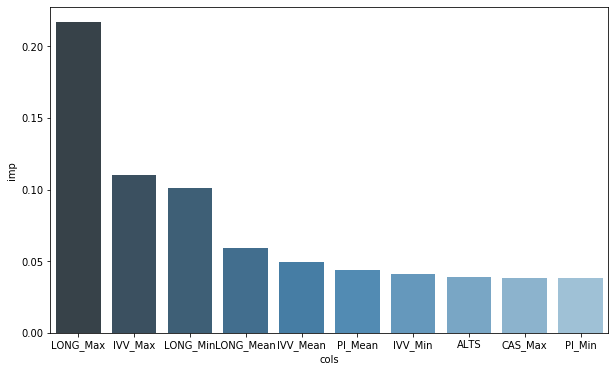

In [20]:
all_imp = feat_importance(
    pre_mod.feature_importances_, train_X.drop(columns="Flight_instance_ID"), True
)

We can see many features that shows (Max, Min, Mean) of same varialbles

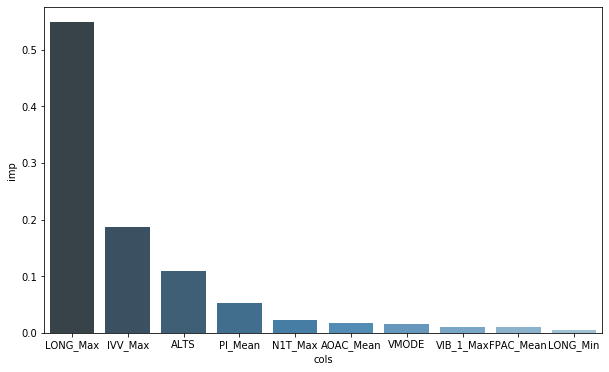

In [21]:
rf_cleaned_X = featcorr.betterval(all_imp, train_X)
cleaned_mod = RandomForestRegressor(n_estimators=25, min_samples_leaf=40)
cleaned_mod.fit(rf_cleaned_X[mask], train_y[mask])
rf_feat = feat_importance(cleaned_mod.feature_importances_, rf_cleaned_X, True)

Now many more unique features appears.

Also there is PDP for feature that RF shows that is the most important (LONG_Max):

<Figure size 504x288 with 0 Axes>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


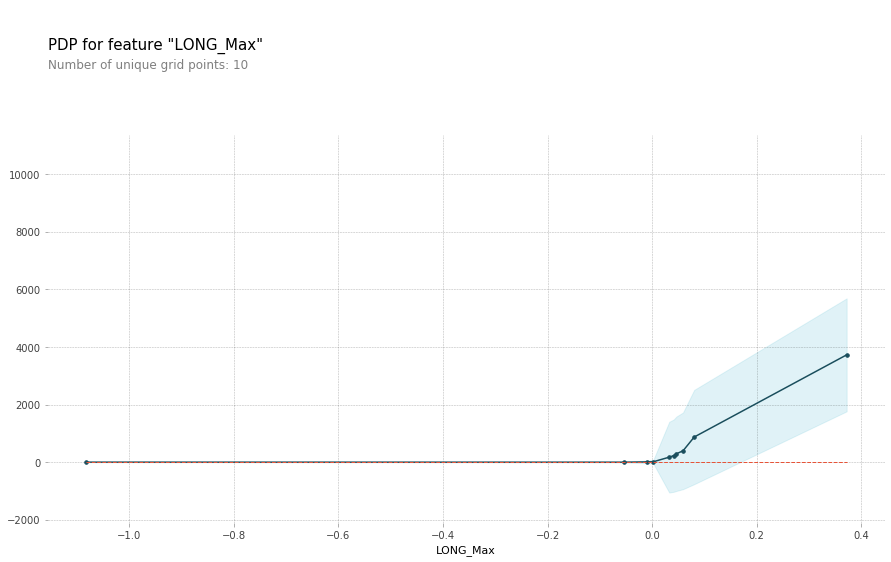

In [22]:
plt.figure(figsize=[7, 4])
pdp_goals = pdp.pdp_isolate(
    model=cleaned_mod,
    dataset=rf_cleaned_X,
    model_features=rf_cleaned_X.columns,
    feature="LONG_Max",
)
pdp.pdp_plot(pdp_goals, "LONG_Max")
plt.show()

##Liner regression feature importance

There features are scaled using Standart Scaler. Bar chart shows feature importance after duplicate remove.

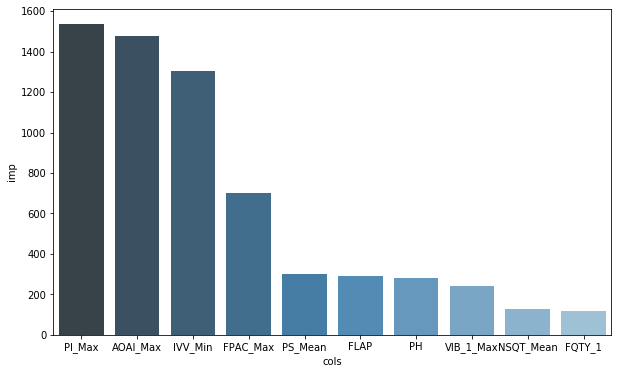

In [23]:
line_ppl = Pipeline(steps=[("reg", StandardScaler()), ("model", LinearRegression())])
line_ppl.fit(train_X.drop(columns="TCAS"), train_y)

line_imp = feat_importance(line_ppl["model"].coef_, train_X.drop(columns="TCAS"))
line_cleaned_X = featcorr.betterval(line_imp, train_X.drop(columns="TCAS"))
line_ppl.fit(line_cleaned_X, train_y)
line_feat = feat_importance(line_ppl["model"].coef_, line_cleaned_X, True)

Reg plot of most important feature:

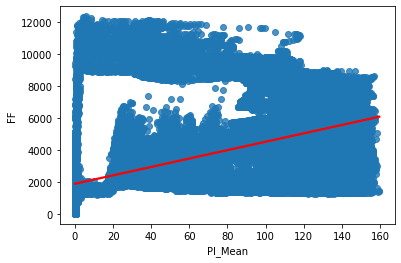

In [24]:
sns.regplot(x="PI_Mean", y="FF", data=train, line_kws={"color": "red"})

##F-regression

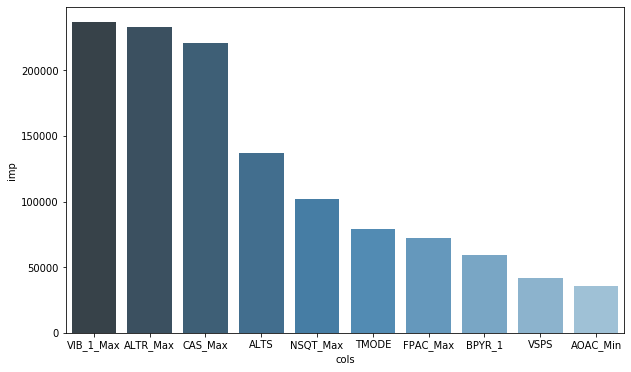

In [25]:
f_imp = feat_importance(f_regression(train_X, train_y)[0], train_X, False)
f_cleaned_X = featcorr.betterval(f_imp, train_X)
f_feat = feat_importance(f_regression(f_cleaned_X, train_y)[0], f_cleaned_X, True)

##Variance

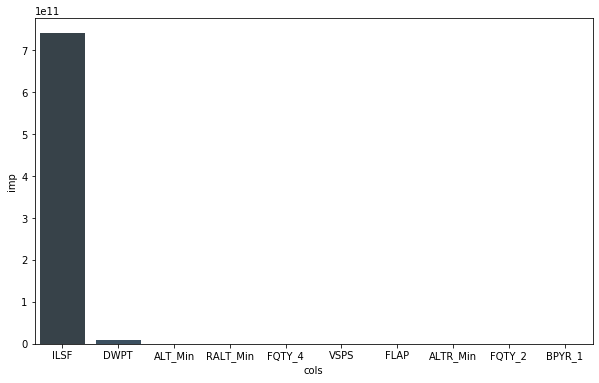

In [26]:
for_var = train_X.drop(columns=["Flight_instance_ID", "elapsed"])
var_imp = feat_importance(for_var.var().values, for_var)
var_cleaned_X = featcorr.betterval(var_imp, for_var)
var_feat = feat_importance(var_cleaned_X.var().values, var_cleaned_X, True)

Scatter plot of features with high variance

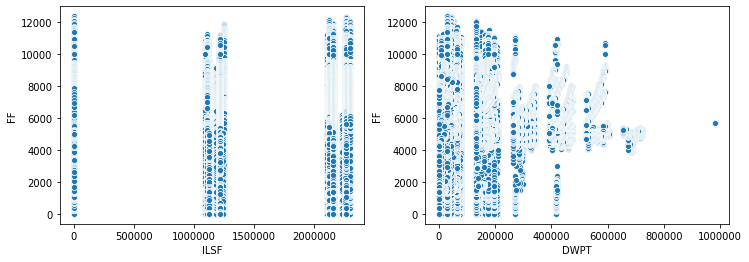

In [27]:
fig, axve = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(x="ILSF", y="FF", data=train, ax=axve[0])
sns.scatterplot(x="DWPT", y="FF", data=train, ax=axve[1])
plt.show()

We can see clear clusters of thouse features

##Final train set creation

In [0]:
rf_col = rf_feat[:25].index.values
line_col = line_feat[:10].index.values
f_col = f_feat[:10].index.values
var_col = var_feat[:5].index.values
col_selec = np.unique(
    np.concatenate(
        (rf_col, line_col, f_col, var_col, ["elapsed", "Flight_instance_ID"])
    )
)
trainimp_X = train_X[col_selec]

In [0]:
forsave = trainimp_X
forsave["FF"] = train_y
forsave.reset_index().to_feather("Backup")

#Preprocessing 

In [0]:
forsave = pd.read_feather("Backup")
trainimp_X = forsave.drop(columns="FF")
trainimp_X.set_index("index", inplace=True)
trainimp_X.index.name = ""
train_y = forsave["FF"]
train_y.index = trainimp_X.index

First thing that I noticed is two columns that have high importance according to RF (LONG_Max, CAS_Max) have rows that are deffinetelly an outliers (orange on scatter plots).

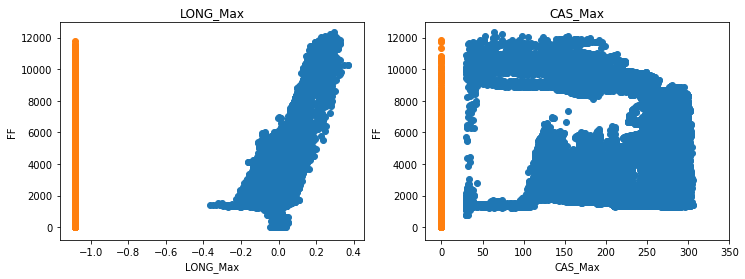

In [31]:
long_out = trainimp_X["LONG_Max"] < -1
cas_out = trainimp_X["CAS_Max"] < 3
fig, axve = plt.subplots(1, 2, figsize=(12, 4))
axve[0].scatter(trainimp_X[~long_out]["LONG_Max"], train_y[~long_out])
axve[0].scatter(trainimp_X[long_out]["LONG_Max"], train_y[long_out])
axve[0].title.set_text("LONG_Max")
axve[0].set_xlabel("LONG_Max")
axve[0].set_ylabel("FF")
axve[1].scatter(trainimp_X[~cas_out]["CAS_Max"], train_y[~cas_out])
axve[1].scatter(trainimp_X[cas_out]["CAS_Max"], train_y[cas_out])
axve[1].title.set_text("CAS_Max")
axve[1].set_xlabel("CAS_Max")
axve[1].set_ylabel("FF")
axve[1].set_xlim(-20, 350)
plt.show()

There is features with less than 15 unique values

In [0]:
unval = trainimp_X.nunique()
unval = unval[unval < 15].index

<div>Pipeline for preprocessing.</div>
<div>Encoder:</div>
<div>MintoMean - used for columns with outliers mentioned earlier. Replaces Min value with Mean and creates column with indicators of replced values.</div>
<div>FlightPart - calculte 3 values: duration of a flight, time after begining and value from 0 to 1 that shows already flown part.</div>
<div>ClustTarg - allows cluster data using K-means algoritm and encode as categorical feature</div>


In [0]:
unval = ["OIPL", "PH", "TMODE", "VMODE"]
others = compr(
    trainimp_X.columns, ["elapsed", "Flight_instance_ID", "LONG_Max", "CAS_Max"]
)
ct = ColumnTransformer(
    transformers=[
        ("simdt", MintoMean(0.01), ["LONG_Max", "CAS_Max"]),
        (
            "flighper",
            FlightPart("elapsed", "Flight_instance_ID"),
            ["elapsed", "Flight_instance_ID"],
        ),
        ("nother", DoNothing(), others),
    ],
    remainder="drop",
)
ppl = Pipeline(steps=[("main", ct)])

In [34]:
train_fin_X = ppl_to_df(ppl, "main", trainimp_X, train_y)
train_fin_X.head(3)

,LONG_Max,CAS_Max,LONG_Max_out,CAS_Max_out,elapsed,from_beg,duration,part,ALTR_Max,ALTS,ALT_Min,AOA1_Max,AOAC_Mean,AOAC_Min,AOAI_Max,BLV,BPYR_1,CASM_Max,DWPT,EAI,FGC3,FLAP,FPAC_Max,FPAC_Mean,FQTY_1,FQTY_4,ILSF,IVV_Max,IVV_Min,LATP,LONG_Min,MSQT_2_Mean,N1T_Max,NSQT_Max,NSQT_Mean,OIPL,PH,PI_Max,PI_Mean,PS_Mean,RALT_Min,TAT,TMODE,VIB_1_Max,VMODE,VSPS,WS_Min
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
656709,-0.000752,255.786097,0.0,1.0,1.066974e+09,0.0,7375.0,0.000000,16.0,5000.0,707.0,-0.087890,0.0,0.0,-2.241195,0.0,43.945423,300.0,131164.0,0.0,120.0,94.0,0.0,0.0,8168.0,8072.0,2303077.0,1.0,0.0,41.303789,-0.004816,0.0,84.28125,0.0,0.0,0.0,1.0,0.06250,0.062500,29.176151,-0.625,-1.5,2.0,0.0,11.0,0.0,0.0
656714,-0.009388,255.786097,0.0,1.0,1.066974e+09,5.0,7375.0,0.000678,0.0,5000.0,707.0,-0.087890,0.0,0.0,-2.241195,0.0,48.828247,300.0,131164.0,0.0,120.0,95.0,0.0,0.0,8168.0,8072.0,2303077.0,0.0,0.0,41.303789,-0.009896,0.0,84.28125,0.0,0.0,0.0,1.0,0.09375,0.078125,29.176151,-0.625,-1.5,2.0,0.0,11.0,0.0,0.0
656715,-0.009388,255.786097,0.0,1.0,1.066974e+09,6.0,7375.0,0.000814,16.0,5000.0,708.0,-0.131835,0.0,0.0,-2.241195,0.0,43.945423,300.0,131164.0,0.0,120.0,95.0,0.0,0.0,8168.0,8072.0,2303077.0,0.0,0.0,41.303789,-0.010404,0.0,84.28125,0.0,0.0,0.0,1.0,0.09375,0.062500,29.176151,-0.625,-1.5,2.0,0.0,11.0,0.0,0.0


## More about consumption during a flight

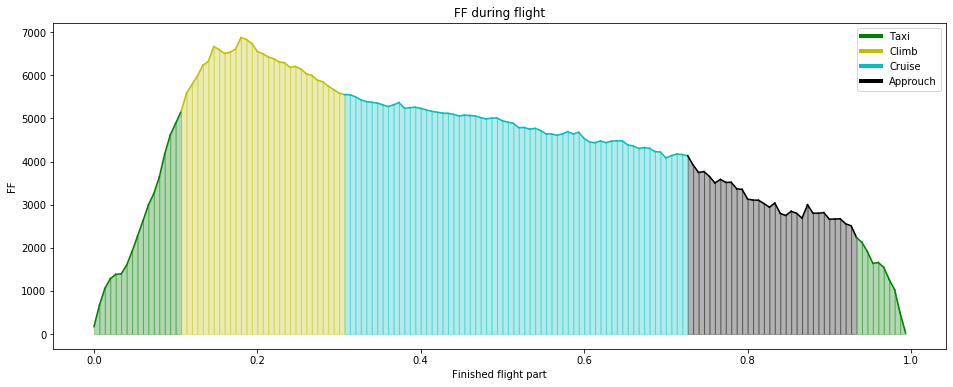

In [35]:
colors = {1: "r", 2: "g", 4: "y", 5: "c", 6: "k", 7: "m"}
fins = FFpart(train_fin_X, train_y, 1 / 150, colors)
fig, axpa = plt.subplots(1, 1, figsize=(16, 6))
prev = fins.iloc[0]
counter = 0
for key, val in fins.iloc[1:].iterrows():
    axpa.plot(
        [prev["part"], val["part"]], [prev["cons"], val["cons"]], color=val["type"]
    )
    axpa.fill_between(
        [prev["part"], val["part"]],
        [prev["cons"], val["cons"]],
        color=val["type"],
        alpha=0.3,
    )
    prev = val

axpa.title.set_text("FF during flight")
axpa.set_xlabel("Finished flight part")
axpa.set_ylabel("FF")

custom_lines = [(Line2D([0], [0], color=col[1], lw=4)) for col in colors.items()][1:-1]
plt.legend(custom_lines, ["Taxi", "Climb", "Cruise", "Approuch"])
plt.show()



*   We can see from graph that plane during climb through dense layers of air consumes most of fule.
*   And later during the flight plane becomes lighter and consumes less fuel. 


<div>There is also 3 stages of flight (Preflight, Rollout, Takeoff) that are not represented in the graph because they are too short to be shown with this graph approximation level.</div>
<div>First Taxi stage may be a little bit larger because of the same reason (Takeoff stage is between it and climb) </div>

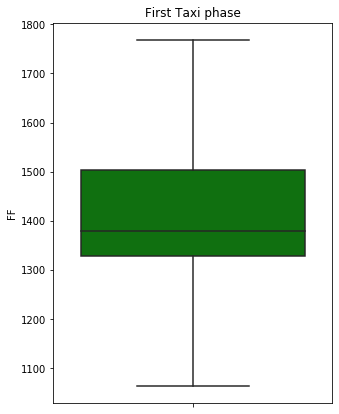

In [36]:
forplot = train_fin_X
forplot["FF"] = train_y
fig, axta = plt.subplots(1, 1, figsize=(5, 7))
lgmask = np.logical_and(forplot["PH"] == 2, forplot["part"] < 0.5)
sns.boxplot(forplot[lgmask]["FF"], orient="v", showfliers=False, color="g", ax=axta)
axta.title.set_text("First Taxi phase")
plt.show()

# Model and hyper parameter selection

In [0]:
msks = 30000
mask = np.concatenate([np.zeros(train_fin_X.shape[0] - msks), np.ones(msks)]).astype(
    "bool"
)
np.random.shuffle(mask)

In [0]:
ppltr = Pipeline(steps=[("target", TargetEncoder(cols=unval)), ("main", ct)])
train_fin_X = ppl_to_df(ppltr, "main", train_X, train_y)

## Hyper parameters for grid search


In [0]:
xg_grid = [
    {"max_depth": [7, 8, 9], "min_child_weight": [1, 3, 6]},
    {"gamma": [i / 10.0 for i in range(0, 3)]},
    {"subsample": [0.2, 0.5, 0.8], "colsample_bytree": [0.1, 0.6, 0.9]},
    {"reg_alpha": [1e-5, 1e-2, 0.1, 1, 100]},
]

In [0]:
gradient_grid = [
    {"max_depth": [3, 8, 12]},
    {"max_features": [5, 23, 36, 70]},
    {"n_estimators": [100, 200, 400], "learning_rate": [0.03, 0.1, 0.5, 1]},
    {"loss": ["ls", "lad", "huber", "quantile"]},
]

In [0]:
ada_grid = [
    {"base_estimator": [DecisionTreeRegressor(max_depth=i) for i in [3, 5, 8, 10]]},
    {"n_estimators": [50, 100, 200, 350], "learning_rate": [1, 0.5, 0.1]},
]

In [0]:
rf_grid = [
    {"min_samples_leaf": [1, 5, 10]},
    {"min_samples_split": [1, 5, 10, 20]},
    {"max_features": ["auto", 0.2, 0.4, 0.6]},
    {"bootstrap": [True, False]},
]

## Grid search

In [0]:
xg_test = XGBRegressor(n_estimators=50)
search_by_line(xg_test, xg_grid, train_fin_X[mask], train_y[mask])

[23:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:16:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.8, 'reg_alpha': 1e-05}


In [0]:
gb_test = GradientBoostingRegressor()
search_by_line(gb_test, gradient_grid, train_fin_X[mask], train_y[mask])

{'max_depth': 8, 'max_features': 23, 'learning_rate': 0.03, 'n_estimators': 400, 'loss': 'huber'}


In [0]:
adatree_test = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=12), learning_rate=1
)
search_by_line(adatree_test, ada_grid, train_fin_X[mask], train_y[mask])

{'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best'), 'learning_rate': 1, 'n_estimators': 50}


In [0]:
rf_test = RandomForestRegressor(n_estimators=20)
search_by_line(rf_test, rf_grid, train_fin_X[mask], train_y[mask], True)

{'min_samples_leaf': 1}
{'min_samples_split': 5}
{'max_features': 0.2}
{'bootstrap': False}
{'min_samples_leaf': 1, 'min_samples_split': 5, 'max_features': 0.2, 'bootstrap': False}


## Results with test set

In [0]:
test_fin = ppl_to_df(ppltr, "main", test_X, test_y, False)

### Random forest

In [0]:
rf_mod = RandomForestRegressor(
    n_estimators=50,
    min_samples_leaf=1,
    min_samples_split=5,
    max_features=0.4,
    bootstrap=False,
)
rf_mod.fit(train_fin_X[mask], train_y[mask])
rmse(test_y, rf_mod.predict(test_fin))

222.70635875477282

### AdaBoost

In [0]:
ada_mod = AdaBoostRegressor(
    n_estimators=200, base_estimator=DecisionTreeRegressor(max_depth=12)
)
ada_mod.fit(train_fin_X[mask], train_y[mask])
rmse(test_y, ada_mod.predict(test_fin))

235.85020862047293

### Gradient Boost

In [0]:
gb_mod = GradientBoostingRegressor(
    max_depth=8, max_features=23, learning_rate=0.03, n_estimators=400, loss="ls"
)
gb_mod.fit(train_fin_X[mask], train_y[mask])
rmse(test_y, gb_mod.predict(test_fin))

208.00102685888174

### XGBoost

In [56]:
xg_reg = XGBRegressor(
    n_estimators=5000,
    max_depth=8,
    min_child_weight=3,
    gamma=0,
    colsample_bytree=0.6,
    subsample=0.8,
    reg_alpha=1,
    learning_rate=0.03,
)
xg_reg.fit(
    train_fin_X[mask],
    train_y[mask],
    early_stopping_rounds=5,
    eval_set=[(test_fin, test_y)],
    verbose=False,
)
rmse(test_y, xg_reg.predict(test_fin))

[10:06:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


207.2239298587225

In [57]:
xg_reg.best_iteration

465

# Final model

In [0]:
traincnc_X = pd.concat([trainimp_X, test_X[trainimp_X.columns]], ignore_index=True)
taincnc_y = pd.concat([train_y, test_y], ignore_index=True)
train_cnX = ppl_to_df(ppltr, "main", traincnc_X, taincnc_y)
val_fin = ppl_to_df(ppltr, "main", val_X[traincnc_X.columns], train_y, False)

In [43]:
xg_fin = XGBRegressor(
    n_estimators=447,
    max_depth=8,
    min_child_weight=3,
    gamma=0,
    colsample_bytree=0.6,
    subsample=0.8,
    reg_alpha=1,
    learning_rate=0.03,
)
xg_fin.fit(train_cnX, taincnc_y)

[09:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=8, min_child_weight=3, missing=None, n_estimators=447,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [44]:
rmse(val_y, xg_fin.predict(val_fin))

179.77947832063563

In [45]:
mean_squared_error(val_y, xg_fin.predict(val_fin))

32320.6608252399